# Go Term Analysis (dev)

In [1]:
import os

os.chdir('../..')
os.getcwd()

'/home/dbm829/projects/interpreting_omics_models'

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Go terms to gene lists prep

### Get GO term graph

In [2]:
# get go term reference 
if not os.path.exists('01_data/go-basic.obo'):
    os.chdir('01_data')
    !wget https://purl.obolibrary.org/obo/go/go-basic.obo -O go-basic.obo
    !pip install goatools
    os.chdir('..')
from goatools.obo_parser import GODag
obodag = GODag("01_data/go-basic.obo")

01_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [3]:
obodag

{'GO:0000001': GOTerm('GO:0000001'):
   id:GO:0000001
   item_id:GO:0000001
   name:mitochondrion inheritance
   namespace:biological_process
   _parents: 2 items
     GO:0048308
     GO:0048311
   parents: 2 items
     GO:0048308	level-05	depth-05	organelle inheritance [biological_process]
     GO:0048311	level-04	depth-04	mitochondrion distribution [biological_process]
   children: 0 items
   level:5
   depth:6
   is_obsolete:False
   alt_ids: 0 items,
 'GO:0000002': GOTerm('GO:0000002'):
   id:GO:0000002
   item_id:GO:0000002
   name:mitochondrial genome maintenance
   namespace:biological_process
   _parents: 1 items
     GO:0007005
   parents: 1 items
     GO:0007005	level-05	depth-05	mitochondrion organization [biological_process]
   children: 0 items
   level:6
   depth:6
   is_obsolete:False
   alt_ids: 0 items,
 'GO:0000006': GOTerm('GO:0000006'):
   id:GO:0000006
   item_id:GO:0000006
   name:high-affinity zinc transmembrane transporter activity
   namespace:molecular_functio

In [26]:
# create a dataframe with each go term and its level
import pandas as pd

go_names = []
go_levels = []
for go_id in obodag:
    go_names.append(obodag[go_id].name)
    go_levels.append(obodag[go_id].level)

df_go_levels = pd.DataFrame({'go_id': list(obodag.keys()), 'go_name': go_names, 'go_level': go_levels})
df_go_levels

,go_id,go_name,go_level
0,GO:0000001,mitochondrion inheritance,5
1,GO:0000002,mitochondrial genome maintenance,6
2,GO:0000006,high-affinity zinc transmembrane transporter a...,8
3,GO:0000007,low-affinity zinc ion transmembrane transporte...,8
4,GO:0000009,"alpha-1,6-mannosyltransferase activity",6
...,...,...,...
44012,GO:0090645,ubiquitin ligase inhibitor activity,5
44013,GO:0035926,regulation of chemokine (C-X-C motif) ligand 2...,6
44014,GO:1904207,regulation of chemokine (C-X-C motif) ligand 2...,6
44015,GO:1904208,negative regulation of chemokine (C-X-C motif)...,7


In [29]:
# save the dataframe
df_go_levels.to_csv('01_data/go_term_levels.tsv', sep='\t', index=False)

### Get proteins and associated GO terms

In [3]:
# get go term reference 
if not os.path.exists('01_data/goa_human.gaf'):
    os.chdir('01_data')
    !wget https://current.geneontology.org/annotations/goa_human.gaf.gz -O goa_human.gaf.gz
    !gunzip goa_human.gaf.gz
    !rm goa_human.gaf.gz
    os.chdir('..')
from goatools.anno.gaf_reader import GafReader

ogaf = GafReader("01_data/goa_human.gaf")

HMS:0:00:07.819722 782,823 annotations READ: 01_data/goa_human.gaf 


In [4]:
ns2assc = ogaf.get_ns2assc()

In [10]:
ns2assc

{'MF': {'A0A024RBG1': {'GO:0000298',
   'GO:0003723',
   'GO:0005515',
   'GO:0008486',
   'GO:0034431',
   'GO:0034432',
   'GO:0046872'},
  'A0A075B759': {'GO:0003755', 'GO:0016018', 'GO:0140839', 'GO:0140840'},
  'A0A075B767': {'GO:0003755', 'GO:0016018', 'GO:0140839', 'GO:0140840'},
  'A0A087WT01': {'GO:0005515'},
  'A0A087WUV0': {'GO:0000978', 'GO:0000981', 'GO:0046872'},
  'A0A087X1C5': {'GO:0005506', 'GO:0016712', 'GO:0020037', 'GO:0070330'},
  'A0A096LNW5': {'GO:0005509'},
  'A0A096LP01': {'GO:0005515', 'GO:0019901', 'GO:0044325'},
  'A0A096LP49': {'GO:0008017'},
  'A0A096LPK9': {'GO:0004930', 'GO:0004984'},
  'A0A0A6YYK7': {'GO:0042287', 'GO:0042605'},
  'A0A0B4J2A2': {'GO:0003755', 'GO:0016018', 'GO:0140839', 'GO:0140840'},
  'A0A0B4J2F0': {'GO:0005515'},
  'A0A0C5B5G6': {'GO:0003677', 'GO:0140297'},
  'A0A0G2JMH3': {'GO:0003924', 'GO:0005525'},
  'A0A0G2JNH3': {'GO:0004930', 'GO:0004984'},
  'A0A0J9YWL9': {'GO:0003729', 'GO:0046872'},
  'A0A0J9YY54': {'GO:0003729', 'GO:00468

In [5]:
all_proteins = list(ns2assc['BP'].keys()) + list(ns2assc['MF'].keys()) + list(ns2assc['CC'].keys())
all_proteins = list(set(all_proteins))
print(len(all_proteins))

44588


### Get protein to ensembl mapping

In [6]:
# I need protein name to ensemble conversion
import pandas as pd

if not os.path.exists('01_data/protname2ensembl.tsv'):
    os.chdir('01_data')
    if not os.path.exists('idmapping_selected.tab'):
        !wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/idmapping_selected.tab.gz
        !gunzip idmapping_selected.tab.gz
    else:
        print('idmapping_selected.tab already downloaded')
    os.chdir('..')
    id_mapping = pd.read_csv('01_data/idmapping_selected.tab', sep='\t', header=None)
    # filter for only protein id and ensembl id and human proteins
    prot2ensembl = id_mapping[[0, 16, 18]]
    prot2ensembl.columns = ['UniProtKB-AC', 'EMBL', 'Ensembl']
    prot2ensembl = prot2ensembl.dropna()
    # save the file
    prot2ensembl.to_csv('01_data/protname2ensembl.tsv', sep='\t', index=False)
    !rm idmapping_selected.tab.gz
    !rm idmapping_selected.tab
else:
    prot2ensembl = pd.read_csv('01_data/protname2ensembl.tsv', sep='\t')

In [13]:
prot2ensembl

,UniProtKB-AC,EMBL,Ensembl
0,Q60888,BC141260; AY318157; AY073853; U28777,ENSMUSG00000062121.4
1,Q8VBW9,AF281257; AY073151; AY317466,ENSMUSG00000054666.8
2,Q60885,AY073230; AY317937; U28774,ENSMUSG00000069430.4
3,Q5ZLQ6,AJ719678,ENSGALG00000004143; ENSGALG00010022076.1; ENSG...
4,P31946,X57346; AK292717; AL008725; CH471077; CH471077...,ENSG00000166913.13
...,...,...,...
879405,A7KII2,EF427379,ENSSSAG00000040701
879406,A0A1B8XVI6,KV461331,ENSXETG00000027086
879407,B7ZTZ7,BC171051,ENSXETG00000038419
879408,B7ZTQ4,BC170957,ENSXETG00000019929


In [19]:
human_idx = [i for i, x in enumerate(prot2ensembl['Ensembl']) if 'ENSG0' in x]
prot2ensembl.iloc[human_idx]

,UniProtKB-AC,EMBL,Ensembl
4,P31946,X57346; AK292717; AL008725; CH471077; CH471077...,ENSG00000166913.13
12,P62258,U20972; U54778; U43399; U43430; U28936; AB0171...,ENSG00000108953.17; ENSG00000274474.3
16,Q04917,L20422; X80536; X78138; X57345; D78577; S80794...,ENSG00000128245.15
19,P61981,AF142498; AB024334; CR541904; CR541925; AC0063...,ENSG00000170027.7
23,P31947,M93010; X57348; AF029081; AF029082; CR541905; ...,ENSG00000175793.12
...,...,...,...
112158,H7C3R6,AC114489; AL033529; AL138800; KF495898; KF495904,ENSG00000176261
112159,A0A0A6YYI9,AP001157,ENSG00000248643
112160,C9IZ13,AC110491,ENSG00000113966.10
112161,A0A2R8YD15,AC022506,ENSG00000285133


### Load sc data to get relevant genes

In [7]:
# test out what names I need to convert to to match my data

# load data
import anndata as ad

adata = ad.read_h5ad('01_data/human_bonemarrow.h5ad')

In [16]:
adata.var

,feature_types,gene_id,modality
AL627309.5,GEX,ENSG00000241860,GEX
LINC01409,GEX,ENSG00000237491,GEX
LINC01128,GEX,ENSG00000228794,GEX
NOC2L,GEX,ENSG00000188976,GEX
KLHL17,GEX,ENSG00000187961,GEX
...,...,...,...
GL000219.1-90062-90937,ATAC,NaN,ATAC
GL000219.1-99257-100160,ATAC,NaN,ATAC
KI270726.1-27152-28034,ATAC,NaN,ATAC
KI270713.1-21434-22336,ATAC,NaN,ATAC


In [12]:
sc_gene_ids = adata.var[adata.var['modality']=='GEX']['gene_id'].values
sc_gene_ids

['ENSG00000241860', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000188976', 'ENSG00000187961', ..., 'ENSG00000198786', 'ENSG00000198695', 'ENSG00000198727', 'ENSG00000273748', 'ENSG00000271254']
Length: 13431
Categories (13431, object): ['ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938', ..., 'ENSG00000288093', 'ENSG00000288107', 'ENSG00000288156', 'ENSG00000288380']

In [21]:
def find_prot_entry(gene_id):
    idx = [i for i, x in enumerate(prot2ensembl['Ensembl']) if gene_id in x]
    if len(idx) > 0:
        return idx[0]
    else:
        return None

found_entries = []
for gene_id in sc_gene_ids:
    found_entries.append(find_prot_entry(gene_id))
prot_names = [prot2ensembl.iloc[i]['UniProtKB-AC'] if i is not None else None for i in found_entries]
prot_names

[None,
 None,
 None,
 'Q9Y3T9',
 'Q6TDP4',
 'P05161',
 'Q96HA4',
 'G3V1E2',
 'Q96L58',
 'Q8N2K1',
 'Q96P50',
 'Q5TA45',
 'O14640',
 'Q9NWT8',
 'Q96S94',
 'Q9BYC9',
 'Q5T9A4',
 'Q9NVI7',
 'Q9NP77',
 'Q96AX9',
 'O75900',
 'P21127',
 'P0CK96',
 'Q9UQ88',
 None,
 'O95544',
 'P62873',
 'Q05513',
 'Q6NZ36',
 'P12755',
 'Q5T089',
 'O15258',
 'O60683',
 'O75038',
 'Q9NVE7',
 None,
 None,
 'Q92956',
 'Q8TBF2',
 'A8MYJ7',
 'O75095',
 'Q5T0D9',
 'Q9P2S5',
 'B2RUZ4',
 'Q8N1G4',
 'O60308',
 'O76075',
 'Q8IYL3',
 'O75161',
 'Q13303',
 'P35268',
 'O60725',
 'Q6NV75',
 'O00154',
 'B1AK53',
 'Q93038',
 'Q5SY16',
 'P10074',
 'Q9UJP4',
 'Q86YI8',
 'Q8WTV1',
 'Q9NVH1',
 'Q9Y6Y1',
 'Q15836',
 'P56645',
 'Q07011',
 'Q99497',
 'Q9UJM3',
 'Q9P2R6',
 None,
 'P06733',
 'P22732',
 'Q5UAW9',
 'O95479',
 'Q96BD6',
 'Q9BSK2',
 'Q5SNT2',
 'O00329',
 None,
 'O94985',
 'Q9NSA3',
 'Q8WZA0',
 'Q9HAN9',
 'Q96R05',
 'O95155',
 'O60333',
 'P52209',
 'O00273',
 'O75381',
 'Q86V15',
 'Q13148',
 None,
 'P19623',
 'Q01780',
 '

In [22]:
# how many are missing
sum([x is None for x in prot_names])

1757

## link go terms to adata-formatted vector ("gene list")

In [30]:
import numpy as np
go_gene_matrix  = np.zeros((len(obodag.keys()), len(prot_names)))

# go through all go terms
count = 0
for protein in prot_names:
    if protein is not None:
        if protein in ns2assc['BP']:
            if len(ns2assc['BP'][protein]) > 0:
                for go_term in ns2assc['BP'][protein]:
                    if go_term in obodag.keys():
                        go_gene_matrix[list(obodag.keys()).index(go_term), prot_names.index(protein)] = 1
        if protein in ns2assc['MF']:
            if len(ns2assc['MF'][protein]) > 0:
                for go_term in ns2assc['MF'][protein]:
                    if go_term in obodag.keys():
                        go_gene_matrix[list(obodag.keys()).index(go_term), prot_names.index(protein)] = 1
        if protein in ns2assc['CC']:
            if len(ns2assc['CC'][protein]) > 0:
                for go_term in ns2assc['CC'][protein]:
                    if go_term in obodag.keys():
                        go_gene_matrix[list(obodag.keys()).index(go_term), prot_names.index(protein)] = 1

In [40]:
# actually save it as ann andata object with sparse matrix
import scipy.sparse as sp

adata_go = ad.AnnData(sp.csr_matrix(go_gene_matrix), obs=df_go_levels, var=pd.DataFrame({'Ensembl': sc_gene_ids, 'UniProtKB-AC': prot_names}, index=sc_gene_ids))
adata_go.write('01_data/go_gene_matrix.h5ad')
adata_go

/var/folders/c1/jcbft1r124v0ph67_0bnf9nh0000gp/T/ipykernel_7548/2270486497.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_go = ad.AnnData(sp.csr_matrix(go_gene_matrix), obs=df_go_levels, var=pd.DataFrame({'Ensembl': sc_gene_ids, 'UniProtKB-AC': prot_names}, index=sc_gene_ids))
/opt/anaconda3/envs/sc_mechinterp/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 44017 × 13431
    obs: 'go_id', 'go_name', 'go_level'
    var: 'Ensembl', 'UniProtKB-AC'

## load all models

In [3]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# import utils functions
from src.models.sparse_autoencoder import *
from src.visualization.plotting import *

In [4]:
# multiDGD

#data = ad.read_h5ad('./01_data/human_bonemarrow.h5ad') # when on local
data = ad.read_h5ad('/projects/heads/data/singlecell/human_bonemarrow.h5ad') # when on server

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e')

# extract the train representations
reps = model.representation.z.detach()

# from here on I only need the train set
data = data[data.obs["train_val_test"] == "train"]

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


/home/dbm829/.conda/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._save_dir

In [5]:
# SAE

# load the model
sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'

input_size = reps.shape[1]
hidden_size = 10**4
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt', map_location=torch.device(device)))
sae_model.to(device)

batch_size = 128
train_data = reps.clone()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_1028795/529455148.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt', map_location=torch.devic

## compute activations and make model predictions

In [6]:
reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))
del reps_reconstructed

/tmp/ipykernel_1028795/3286488216.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))


In [9]:
# save the activations for later analysis
torch.save(activations.detach().cpu(), '03_results/reports/'+sae_model_save_name.split('/')[-1]+'_activations.pt')

In [7]:
# predict gene expression

# still need the covariate latents for gene expression prediction
cov_reps = model.correction_rep.z.detach()

# feed these latents into the dgd model
# chunk the data into batches
n_genes = len(data.var[data.var['modality']=='GEX'])
y = torch.zeros((reps.shape[0], n_genes)).to(device)
import tqdm
batch_size = 1000
for i in tqdm.tqdm(range(0, reps.shape[0], batch_size)):
    y[i:i+batch_size,:] = model.decoder(torch.cat((reps[i:i+batch_size,:], cov_reps[i:i+batch_size,:]), dim=1))[0].detach()#.cpu()

# the predictions need to be scaled by the sum of the modality
library = data.obs['GEX_n_counts'].values
y = y * torch.tensor(library.reshape(-1, 1)).to(device)

100%|██████████| 57/57 [00:00<00:00, 975.38it/s]


In [8]:
# make space in memory
del reps
del cov_reps
del sae_model
del model

## compute correlations and cosine similarities

In [ ]:
# compute cosine similarity between activations and gene expression

# in one go crashed the kernel
"""
# making the shapes broadcastable
# activations (N x H) -> (N x H x 1)
# y (N x G) -> (N x 1 x G)
# output (H x G) i.e. hidden dims x genes
cos_sim = torch.nn.functional.cosine_similarity(activations.unsqueeze(-1), y.unsqueeze(1), dim=0)
"""

# do it per gene
cos_sim = torch.zeros((activations.shape[1], y.shape[1]))
import tqdm
for i in tqdm.tqdm(range(y.shape[1])):
    cos_sim[:,i] = torch.nn.functional.cosine_similarity(activations, y[:,i].unsqueeze(1), dim=0).detach().cpu()

# save the cosine similarity matrix
torch.save(cos_sim, '03_results/reports/sc_cosine_similarity_matrix.pt')

100%|██████████| 13431/13431 [05:50<00:00, 38.33it/s]


In [ ]:
def pearsonr(a,b):
    #cov = torch.mean((a - a.mean(dim=0).unsqueeze(0)).unsqueeze(1) * (b - b.mean(dim=0).unsqueeze(0)).unsqueeze(-1), dim=0)
    cov = torch.mean((a - a.mean(dim=0)) * (b - b.mean()).unsqueeze(-1), dim=0)
    #std_a = a.std(dim=0)
    std_a = a.std(dim=0)
    #std_b = b.std(dim=0)
    std_b = b.std()
    return cov / (std_a * std_b)


pearson_corr = torch.zeros((activations.shape[1], y.shape[1]))
import tqdm
for i in tqdm.tqdm(range(y.shape[1])):
    pearson_corr[:,i] = pearsonr(activations, y[:,i]).detach().cpu()


# save the cosine similarity matrix
torch.save(pearson_corr, '03_results/reports/sc_pearson_correlation_matrix.pt')

In [8]:
def spearmanr(a,b):
    # check if all values are 0, this should not be computable
    """ # for one by one, but too slow
    #if torch.sum(a) == 0 or torch.sum(b) == 0:
    #    return torch.nan
    #rank_a = torch.argsort(a) + 1
    #rank_b = torch.argsort(b) + 1
    """
    rank_a = torch.argsort(a, dim=0) + 1
    rank_b = torch.argsort(b) + 1
    # the formula is 1 - 6*sum((rank_a - rank_b)^2) / (n^3 - n)
    d = rank_a - rank_b.unsqueeze(1)
    n = a.shape[0]
    return 1 - ((6 * torch.sum(d**2, dim=0)) / (n**3 - n))


spearman_corr = torch.zeros((activations.shape[1], y.shape[1]))
import tqdm
chunk_size = 1000
for i in tqdm.tqdm(range(y.shape[1])): # 2 for loops because cuda runs out of memory with 1
    for j in range(0, activations.shape[1], chunk_size):
        spearman_corr[j:j+chunk_size,i] = spearmanr(activations[:,j:j+chunk_size], y[:,i]).detach().cpu()

# save the cosine similarity matrix
torch.save(spearman_corr, '03_results/reports/sc_spearman_correlation_matrix.pt')

100%|██████████| 13431/13431 [59:15<00:00,  3.78it/s]


# "Statistics" on GO terms and SAE features

### Load results

In [4]:
# activations
activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')
activations.shape

/tmp/ipykernel_940183/567322997.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_ac

torch.Size([56714, 10000])

In [ ]:
# cosine similarity matrix (SAE features x genes)
cos_sim = torch.load('03_results/reports/sc_cosine_similarity_matrix.pt', weights_only=False) # good for sparse vectors
#pearson_corr = torch.load('03_results/reports/sc_pearson_correlation_matrix.pt', weights_only=False) # good for linear relationships
#spearman_corr = torch.load('03_results/reports/sc_spearman_correlation_matrix.pt', weights_only=False) # good for monotonic relationships
print(cos_sim.shape)

torch.Size([10000, 13431])


## Are SAEs worth it?

Check how many SAE features are active, and how many correspond to a single gene.

In [6]:
# get the indices of the dead features
dead_features = torch.where(torch.sum(activations, dim=0) == 0)[0]
active_features = torch.where(torch.sum(activations, dim=0) != 0)[0]

# make sure there is no overlap and that the sum is equal to the total number of features
assert len(dead_features) + len(active_features) == activations.shape[1]
assert set(dead_features).intersection(set(active_features)) == set()

print('{} out of {} features are dead ({} %)'.format(
    len(dead_features),
    activations.shape[1],
    (len(dead_features)/activations.shape[1])*100
    ))

4682 out of 10000 features are dead (46.82 %)


In [7]:
# compute the average number of features active per cell
activity_threshold = 1e-10
active_features_per_gene = torch.sum(activations > activity_threshold, dim=1).float()
avg_active_features_per_gene = torch.mean(active_features_per_gene).item()

print('The average number of features active per cell is {:.2f}'.format(avg_active_features_per_gene))

The average number of features active per cell is 185.70


In [8]:
# for all active features, look at the metrics per gene

def gene_wise_metrics(corr_matrix, active_features, thresholds=(0.95,0.05)):
    # highest metric per gene
    max_corr = torch.max(corr_matrix[active_features,:], dim=0)
    n_relevant_features = torch.sum(corr_matrix[active_features,:] >= thresholds[0], dim=0)
    n_irrelevant_features = torch.sum(corr_matrix[active_features,:] <= thresholds[1], dim=0)
    return {'max': max_corr.values, 'n_relevant': n_relevant_features, 'n_irrelevant': n_irrelevant_features}

cos_sim_genewise = gene_wise_metrics(cos_sim, active_features)
pearson_corr_genewise = gene_wise_metrics(pearson_corr, active_features)
spearman_corr_genewise = gene_wise_metrics(spearman_corr, active_features)


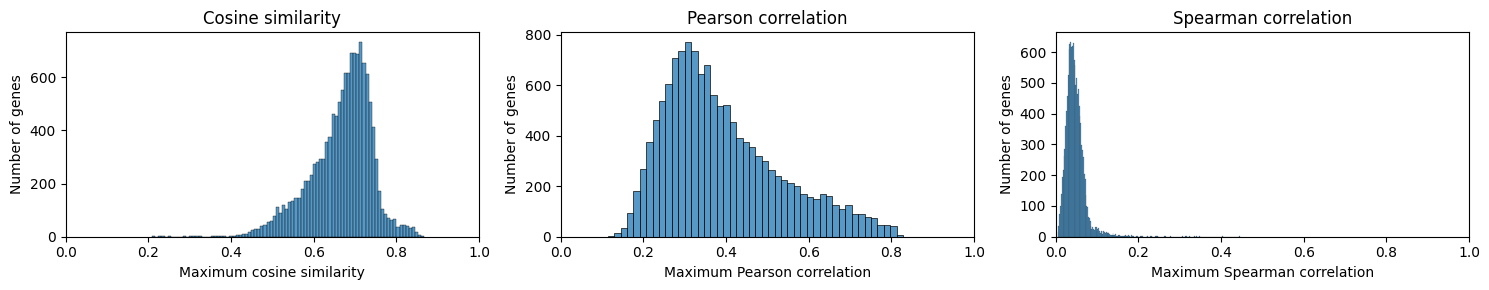

In [22]:
# plot the maximum values

fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.histplot(cos_sim_genewise['max'], ax=ax[0])
ax[0].set_title('Cosine similarity')
ax[0].set_xlabel('Maximum cosine similarity')
ax[0].set_ylabel('Number of genes')
ax[0].set_xlim(0,1)
sns.histplot(pearson_corr_genewise['max'], ax=ax[1])
ax[1].set_title('Pearson correlation')
ax[1].set_xlabel('Maximum Pearson correlation')
ax[1].set_ylabel('Number of genes')
ax[1].set_xlim(0,1)
sns.histplot(spearman_corr_genewise['max'], ax=ax[2])
ax[2].set_title('Spearman correlation')
ax[2].set_xlabel('Maximum Spearman correlation')
ax[2].set_ylabel('Number of genes')
ax[2].set_xlim(0,1)
plt.tight_layout()

### classic thresholds: 0.05, 0.95

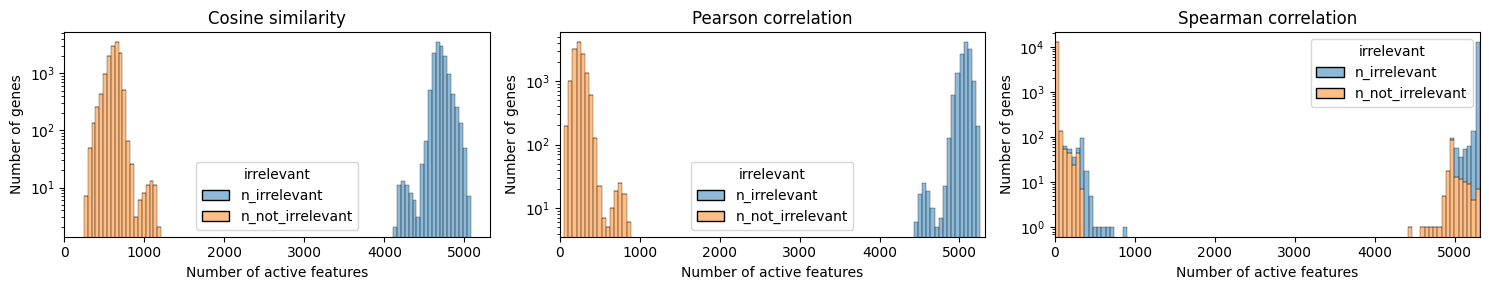

In [51]:
# now look at how many features are not irrelevant (n active features - irrelevant features) and irrelevant

fig, ax = plt.subplots(1, 3, figsize=(15,3))
df_temp = pd.DataFrame({'n_irrelevant': cos_sim_genewise['n_irrelevant'], 'n_not_irrelevant': len(active_features) - cos_sim_genewise['n_irrelevant']})
df_temp = df_temp.melt(value_vars=['n_irrelevant', 'n_not_irrelevant'], var_name='irrelevant', value_name='count')
sns.histplot(data=df_temp, x='count', hue='irrelevant', multiple='stack', ax=ax[0], bins=100, alpha=0.5)
ax[0].set_title('Cosine similarity')
ax[0].set_xlabel('Number of active features')
ax[0].set_ylabel('Number of genes')
ax[0].set_xlim(0,len(active_features))
ax[0].set_yscale('log')
#ax[0].legend(bbox_to_anchor=(0.5,-0.5), loc='lower center')
df_temp = pd.DataFrame({'n_irrelevant': pearson_corr_genewise['n_irrelevant'], 'n_not_irrelevant': len(active_features) - pearson_corr_genewise['n_irrelevant']})
df_temp = df_temp.melt(value_vars=['n_irrelevant', 'n_not_irrelevant'], var_name='irrelevant', value_name='count')
sns.histplot(data=df_temp, x='count', hue='irrelevant', multiple='stack', ax=ax[1], bins=100, alpha=0.5)
ax[1].set_title('Pearson correlation')
ax[1].set_xlabel('Number of active features')
ax[1].set_ylabel('Number of genes')
ax[1].set_xlim(0,len(active_features))
ax[1].set_yscale('log')
#ax[1].legend(bbox_to_anchor=(0.5,-0.5), loc='lower center')
df_temp = pd.DataFrame({'n_irrelevant': spearman_corr_genewise['n_irrelevant'], 'n_not_irrelevant': len(active_features) - spearman_corr_genewise['n_irrelevant']})
df_temp = df_temp.melt(value_vars=['n_irrelevant', 'n_not_irrelevant'], var_name='irrelevant', value_name='count')
sns.histplot(data=df_temp, x='count', hue='irrelevant', multiple='stack', ax=ax[2], bins=100, alpha=0.5)
ax[2].set_title('Spearman correlation')
ax[2].set_xlabel('Number of active features')
ax[2].set_ylabel('Number of genes')
ax[2].set_xlim(0,len(active_features))
ax[2].set_yscale('log')
#ax[2].legend(bbox_to_anchor=(0.5,-0.5), loc='lower center')
plt.tight_layout()

In [57]:
# how many genes have a highly relevant feature?

n_features_per_gene_cos = sum(cos_sim_genewise['n_relevant'] > 0).item()
n_features_per_gene_pearson = sum(pearson_corr_genewise['n_relevant'] > 0).item()
n_features_per_gene_spearman = sum(spearman_corr_genewise['n_relevant'] > 0).item()

print('Cosine similarity: {} genes have at least one highly relevant feature'.format(n_features_per_gene_cos))
print('Pearson correlation: {} genes have at least one highly relevant feature'.format(n_features_per_gene_pearson))
print('Spearman correlation: {} genes have at least one highly relevant feature'.format(n_features_per_gene_spearman))

Cosine similarity: 0 genes have at least one highly relevant feature
Pearson correlation: 0 genes have at least one highly relevant feature
Spearman correlation: 0 genes have at least one highly relevant feature


### quantiles

In [9]:
# replace nan values with 0
pearson_corr[torch.isnan(pearson_corr)] = 0

In [10]:
# this is more sensitive and could lead to more genes

quantiles = (0.05, 0.95)

non_zero_values = cos_sim[active_features,:].flatten()
non_zero_values = non_zero_values[non_zero_values > 0]
threshold_cos = [np.quantile(non_zero_values.numpy(), q) for q in quantiles]
non_zero_values = pearson_corr[active_features,:].flatten()
non_zero_values = non_zero_values[non_zero_values > 0]
threshold_pearson = [np.quantile(non_zero_values.numpy(), q) for q in quantiles]
non_zero_values = spearman_corr[active_features,:].flatten()
non_zero_values = non_zero_values[non_zero_values > 0]
threshold_spearman = [np.quantile(non_zero_values.numpy(), q) for q in quantiles]

print('Cosine similarity: 5th percentile: {:.4f}, 95th percentile: {:.4f}'.format(threshold_cos[0], threshold_cos[1]))
print('Pearson correlation: 5th percentile: {:.4f}, 95th percentile: {:.4f}'.format(threshold_pearson[0], threshold_pearson[1]))
print('Spearman correlation: 5th percentile: {:.4f}, 95th percentile: {:.4f}'.format(threshold_spearman[0], threshold_spearman[1]))

Cosine similarity: 5th percentile: 0.0003, 95th percentile: 0.2621
Pearson correlation: 5th percentile: 0.0004, 95th percentile: 0.0893
Spearman correlation: 5th percentile: 0.0035, 95th percentile: 0.2198


In [11]:
# this is quite specific and could lead to less genes

quantiles = (0.05, 0.95)

threshold_cos_max = [torch.quantile(torch.max(cos_sim, dim=0).values, q) for q in quantiles]
threshold_pearson_max = [torch.quantile(torch.max(pearson_corr, dim=0).values, q) for q in quantiles]
threshold_spearman_max = [torch.quantile(torch.max(spearman_corr, dim=0).values, q) for q in quantiles]

print('Cosine similarity: 5th percentile: {:.2f}, 95th percentile: {:.2f}'.format(threshold_cos_max[0], threshold_cos_max[1]))
print('Pearson correlation: 5th percentile: {:.2f}, 95th percentile: {:.2f}'.format(threshold_pearson_max[0], threshold_pearson_max[1]))
print('Spearman correlation: 5th percentile: {:.2f}, 95th percentile: {:.2f}'.format(threshold_spearman_max[0], threshold_spearman_max[1]))

Cosine similarity: 5th percentile: 0.53, 95th percentile: 0.76
Pearson correlation: 5th percentile: 0.21, 95th percentile: 0.68
Spearman correlation: 5th percentile: 0.02, 95th percentile: 0.08


## What is the GO term coverage of SAE terms?

GO terms are associated with biological processes or molecular functions. They are associated with a set of genes. GO terms are one view of gene expression data that gives more interpretability than single genes.

In [84]:
# basically look at every GO term and all SAE features and check 2 things:
# 1. fraction of the genes involved having similarity metrics above the threshold
# 2. in which percentile are the genes and how much of this top percentile do they cover?

def go_feature_analysis(go_idx, sim_mtrx, threshold):
    # get the genes involved in this go term
    genes = torch.tensor(adata_go.X[go_idx,:].todense()).flatten().bool()
    if torch.sum(genes) == 0:
        return None, None, None
    
    # get the similarity metrics for these genes
    go_sim_mtrx = sim_mtrx[:,genes].clone()
    
    # get the fraction of go genes with similarity above threshold per feature
    frac_per_feature = (go_sim_mtrx > threshold).sum(dim=1).float() / go_sim_mtrx.shape[1]

    # find the lowest value and compute quantile
    # do this relative, so normalized to just look at where the genes are
    sim_mtrx_norm = sim_mtrx.clone() / torch.max(sim_mtrx, dim=1).values.unsqueeze(1)
    # replace nan values with 0
    sim_mtrx_norm[torch.isnan(sim_mtrx_norm)] = 0
    lowest_values = torch.min(sim_mtrx_norm[:,genes], dim=1).values
    feature_quantiles = torch.tensor([torch.quantile(sim_mtrx_norm[i,:], lowest_values[i]) for i in range(sim_mtrx_norm.shape[0])])

    return sum(genes).item(), frac_per_feature, feature_quantiles

def plot_go_gene_metrics(go_idx, sim_mtrx, feat_id):
    genes = torch.tensor(adata_go.X[go_idx,:].todense()).flatten().bool()
    if torch.sum(genes) > 0:
        go_sim_values = sim_mtrx[feat_id,:]
        df_temp = pd.DataFrame({'similarity': go_sim_values, 'gene': genes})
        # make sure that the y max is the same for all categories
        sns.histplot(data=df_temp, x='similarity', hue='gene', bins=100, alpha=0.5, common_norm=False, stat='density')
        plt.title('GO term: {} ()'.format(adata_go.obs['go_id'][go_idx], adata_go.obs['go_name'][go_idx]))

In [12]:
import anndata as ad

adata_go = ad.read('01_data/go_gene_matrix.h5ad')

In [13]:
adata_go.obs

,go_id,go_name,go_level
0,GO:0000001,mitochondrion inheritance,5
1,GO:0000002,mitochondrial genome maintenance,6
2,GO:0000006,high-affinity zinc transmembrane transporter a...,8
3,GO:0000007,low-affinity zinc ion transmembrane transporte...,8
4,GO:0000009,"alpha-1,6-mannosyltransferase activity",6
...,...,...,...
44012,GO:0090645,ubiquitin ligase inhibitor activity,5
44013,GO:0035926,regulation of chemokine (C-X-C motif) ligand 2...,6
44014,GO:1904207,regulation of chemokine (C-X-C motif) ligand 2...,6
44015,GO:1904208,negative regulation of chemokine (C-X-C motif)...,7


In [14]:
adata_go.var

,Ensembl,UniProtKB-AC
ENSG00000241860,ENSG00000241860,NaN
ENSG00000237491,ENSG00000237491,NaN
ENSG00000228794,ENSG00000228794,NaN
ENSG00000188976,ENSG00000188976,Q9Y3T9
ENSG00000187961,ENSG00000187961,Q6TDP4
...,...,...
ENSG00000198786,ENSG00000198786,P03915
ENSG00000198695,ENSG00000198695,P03923
ENSG00000198727,ENSG00000198727,P00156
ENSG00000273748,ENSG00000273748,NaN


### test on a known feature and GO term

In [44]:
# find a GO term that I know should have a feature: Oxygen transport

go_idx = np.where(adata_go.obs['go_name'] == 'oxygen transport')[0][0]
print(adata_go.obs.iloc[go_idx])
print('Row index: {}'.format(go_idx))

go_id             GO:0015671
go_name     oxygen transport
go_level                   5
Name: 8123, dtype: object
Row index: 8123


In [74]:
go_feature_analysis(go_idx, cos_sim[active_features,:], threshold_cos[1])

torch.Size([5318, 13431])


(7,
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([7.9720e-05, 1.1537e-01, 4.7420e-05,  ..., 6.2233e-03, 3.4640e-03,
         4.4458e-05]))

In [85]:
feat = 2306

go_term_n_genes, go_term_feature_fractions, go_term_feature_quantiles = go_feature_analysis(go_idx, cos_sim, threshold_cos[1])

print(go_term_feature_fractions[feat], go_term_feature_quantiles[feat])

tensor(0.8571) tensor(0.1825)


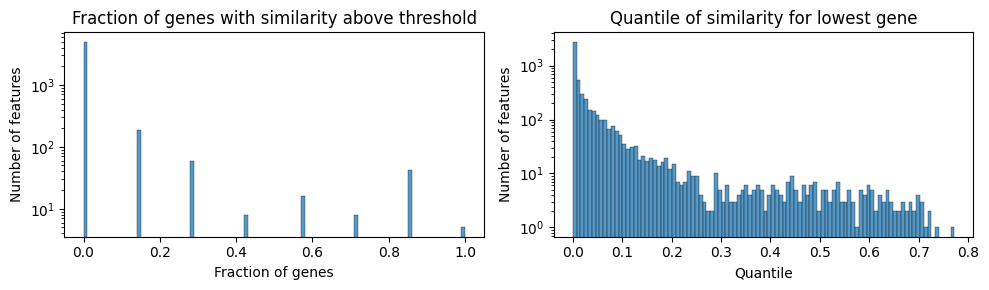

In [86]:
# plot the fractions and quantiles of the active features

fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(go_term_feature_fractions[active_features], ax=ax[0], bins=100)
ax[0].set_title('Fraction of genes with similarity above threshold')
ax[0].set_xlabel('Fraction of genes')
ax[0].set_ylabel('Number of features')
ax[0].set_yscale('log')
sns.histplot(go_term_feature_quantiles[active_features], ax=ax[1], bins=100)
ax[1].set_title('Quantile of similarity for lowest gene')
ax[1].set_xlabel('Quantile')
ax[1].set_ylabel('Number of features')
ax[1].set_yscale('log')
plt.tight_layout()

In [87]:
# which feature contains all of them?

print('Feature {} is the maximum associated feature with GO term {} ({}) with a fraction of {} of the {} genes.'.format(
    go_term_feature_fractions.argmax().item(), 
    adata_go.obs['go_id'][go_idx],
    adata_go.obs['go_name'][go_idx],
    go_term_feature_fractions.max().item(),
    go_term_n_genes
    ))
print('The quantile of this feature is {}.'.format(go_term_feature_quantiles[go_term_feature_fractions.argmax()].item()))
print('The highest quantile of {} is achieved with feature {} with a fraction of {} of the {} genes.'.format(
    go_term_feature_quantiles.max().item(),
    go_term_feature_quantiles.argmax().item(),
    go_term_feature_fractions[go_term_feature_quantiles.argmax()].item(),
    go_term_n_genes
    ))

Feature 5155 is the maximum associated feature with GO term GO:0015671 (oxygen transport) with a fraction of 1.0 of the 7 genes.
The quantile of this feature is 0.7187056541442871.
The highest quantile of 0.7720232009887695 is achieved with feature 4981 with a fraction of 0.7142857313156128 of the 7 genes.


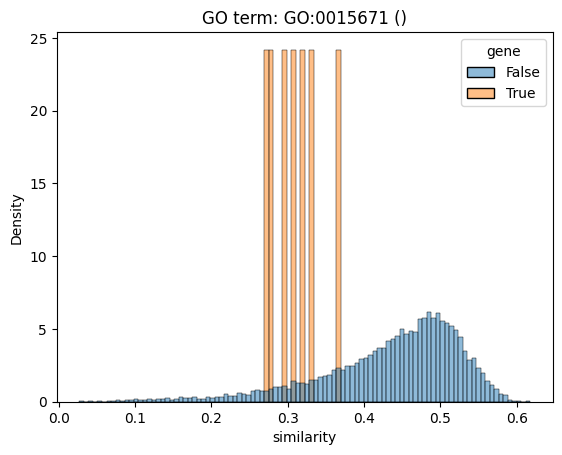

In [88]:
plot_go_gene_metrics(go_idx, cos_sim, go_term_feature_fractions.argmax().item())

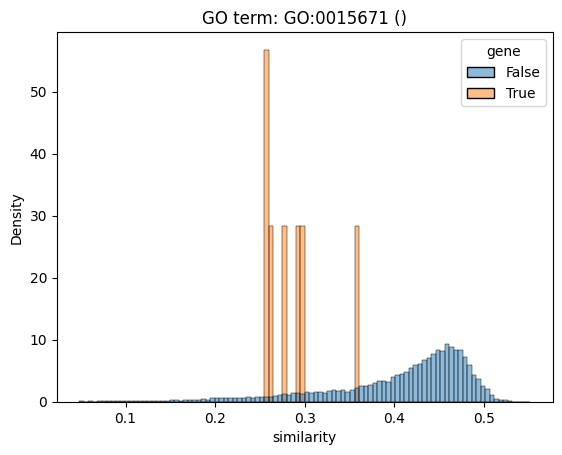

In [89]:
plot_go_gene_metrics(go_idx, cos_sim, go_term_feature_quantiles.argmax().item())

### now across all GO terms

In [ ]:
# moved to script



n_genes = []
best_fractions = []
quantiles_of_best_fractions = []
best_quantiles = []
fractions_of_best_quantiles = []

import tqdm
for go_idx in tqdm.tqdm(range(adata_go.shape[0])):
    go_term_n_genes, go_term_feature_fractions, go_term_feature_quantiles = go_feature_analysis(go_idx, cos_sim, threshold_cos[1])
    if go_term_n_genes is None:
        n_genes.append(0)
        best_fractions.append(0)
        quantiles_of_best_fractions.append(0)
        best_quantiles.append(0)
        fractions_of_best_quantiles.append(0)
    else:
        n_genes.append(go_term_n_genes)
        best_fractions.append(go_term_feature_fractions.max().item())
        quantiles_of_best_fractions.append(go_term_feature_quantiles[go_term_feature_fractions.argmax()].item())
        best_quantiles.append(go_term_feature_quantiles.max().item())
        fractions_of_best_quantiles.append(go_term_feature_fractions[go_term_feature_quantiles.argmax()].item())

df_go_metrics = pd.DataFrame({
    'go_id': adata_go.obs['go_id'],
    'go_name': adata_go.obs['go_name'],
    'go_level': adata_go.obs['go_level'],
    'n_genes': n_genes,
    'best_fraction': best_fractions,
    'quantile_of_best_fraction': quantiles_of_best_fractions,
    'best_quantile': best_quantiles,
    'fraction_of_best_quantile': fractions_of_best_quantiles
    })
#df_go_metrics.to_csv('03_results/reports/go_term_metrics_cosine_similarity.csv', index=False)
#print(df_go_metrics.head())

In [93]:
# show many entries I have per go level

adata_go.obs['go_level'].value_counts()

5     12073
6      8805
4      8184
7      5710
3      4363
8      2332
2      1383
9       711
10      269
11       82
1        76
12       15
0         8
13        6
Name: go_level, dtype: int64

### Go through GO terms and find the ones well explained by the SAE

In [30]:
relevant_go_terms = pd.DataFrame()

for go_level in range(1, 14):
    try:
        df_go_metrics = pd.read_csv('03_results/reports/cos_sim/go_term_summary_cosine_golevel{}.csv'.format(go_level))
        # remove all those with no results
        df_go_metrics = df_go_metrics[df_go_metrics['n_genes'] > 0]
        # keep only fractions of > 0.95
        df_go_metrics = df_go_metrics[df_go_metrics['best_fraction'] > 0.95]
        # keep only quantiles (from best fraction) of > 0.75
        df_go_metrics = df_go_metrics[df_go_metrics['quantile_of_best_fraction'] > 0.75]
        # add them to the relevant terms
        relevant_go_terms = pd.concat([relevant_go_terms, df_go_metrics], axis=0)
    except:
        print('No results for go level {}'.format(go_level))
        continue

No results for go level 3
No results for go level 4


In [31]:
relevant_go_terms

,go_id,go_name,go_level,n_genes,best_fraction,best_fraction_idx,quantile_of_best_fraction,best_quantile,best_quantile_idx,fraction_of_best_quantile
2,GO:0003824,catalytic activity,1,12,1.0,638,0.754603,0.801895,773,1.0
12,GO:0032502,developmental process,1,5,1.0,175,0.859880,0.885695,773,1.0
17,GO:0042592,homeostatic process,1,6,1.0,638,0.758349,0.830506,773,1.0
25,GO:0048511,rhythmic process,1,50,1.0,773,0.775354,0.775354,773,1.0
30,GO:0060090,molecular adaptor activity,1,153,1.0,773,0.751831,0.751831,773,1.0
...,...,...,...,...,...,...,...,...,...,...
3,GO:1902499,positive regulation of protein autoubiquitination,12,3,1.0,638,0.801063,0.832186,3004,1.0
5,GO:1902527,positive regulation of protein monoubiquitination,12,5,1.0,214,0.750656,0.877931,773,1.0
10,GO:1903006,positive regulation of protein K63-linked deub...,12,2,1.0,175,0.850577,0.872915,4706,1.0
1,GO:1900045,negative regulation of protein K63-linked ubiq...,13,4,1.0,175,0.860084,0.902546,773,1.0


In [ ]:
# look at only biological processes

#!pip install goatools
# get go term reference 
if not os.path.exists('01_data/goa_human.gaf'):
    os.chdir('01_data')
    !wget https://current.geneontology.org/annotations/goa_human.gaf.gz -O goa_human.gaf.gz
    !gunzip goa_human.gaf.gz
    !rm goa_human.gaf.gz
    os.chdir('..')
from goatools.anno.gaf_reader import GafReader

ogaf = GafReader("01_data/goa_human.gaf")

ns2assc = ogaf.get_ns2assc()

# get all values of the dictionary
all_bp_terms = []
for key in ns2assc['BP'].keys():
    all_bp_terms.extend(ns2assc['BP'][key])
all_bp_terms = list(set(all_bp_terms))

len(all_bp_terms)

12258

In [ ]:
# this does not look good

sae_feature_go_terms = {}

gene_minimum = 10

for sae_feat in relevant_go_terms.sort_values('best_fraction_idx')['best_fraction_idx'].unique():
    #sae_feature_go_terms[sae_feat] = {}
    # sort by go_level
    df_temp = relevant_go_terms[relevant_go_terms['best_fraction_idx'] == sae_feat].sort_values('go_level')
    # limit it to BP GO terms
    df_temp = df_temp[df_temp['go_id'].isin(all_bp_terms)]
    # limit to sets of at least 10 genes
    df_temp = df_temp[df_temp['n_genes'] >= gene_minimum]
    # take the highest GO level
    df_temp = df_temp[df_temp['go_level'] == df_temp['go_level'].max()]
    if len(df_temp) == 0:
        continue
    sae_feature_go_terms[sae_feat] = list(df_temp['go_name'].values)
    # go through the go levels
    #for go_level in df_temp['go_level'].unique():
    #    # get the go terms
    #    df_temp2 = df_temp[df_temp['go_level'] == go_level]
    #    sae_feature_go_terms[sae_feat][go_level] = list(df_temp2['go_name'].values)

sae_feature_go_terms

{175: ['positive regulation of protein sumoylation'],
 214: ['regulation of mRNA processing'],
 314: ['protein K27-linked ubiquitination',
  'positive regulation of transcription initiation by RNA polymerase II',
  'protein K29-linked ubiquitination',
  'protein K6-linked ubiquitination'],
 598: ['late endosome to lysosome transport'],
 638: ['positive regulation of type 2 mitophagy',
  'positive regulation of peptidyl-serine phosphorylation',
  'positive regulation of transcription by RNA polymerase I',
  'positive regulation of transcription by RNA polymerase III'],
 773: ['negative regulation of protein ubiquitination'],
 4981: ['regulation of apoptotic process'],
 5660: ['motor neuron axon guidance']}

## try the other way around again: from feature to GO term

1. for each feature, rank cosine similarities of all genes
2. go through the BP GO terms, get associated genes and check what percentage is in the equal number top ranked genes

In [98]:
# look at only biological processes

#!pip install goatools
# get go term reference 
if not os.path.exists('01_data/goa_human.gaf'):
    os.chdir('01_data')
    !wget https://current.geneontology.org/annotations/goa_human.gaf.gz -O goa_human.gaf.gz
    !gunzip goa_human.gaf.gz
    !rm goa_human.gaf.gz
    os.chdir('..')
from goatools.anno.gaf_reader import GafReader

ogaf = GafReader("01_data/goa_human.gaf")

ns2assc = ogaf.get_ns2assc()

# get all values of the dictionary
all_bp_terms = []
for key in ns2assc['BP'].keys():
    all_bp_terms.extend(ns2assc['BP'][key])
all_bp_terms = list(set(all_bp_terms))
# add molecular functions
all_mf_terms = []
for key in ns2assc['MF'].keys():
    all_mf_terms.extend(ns2assc['MF'][key])
all_mf_terms = list(set(all_mf_terms))
accepted_terms = all_bp_terms + all_mf_terms

import anndata as ad

adata_go = ad.read('01_data/go_gene_matrix.h5ad')

# limit the go terms to only biological processes
adata_go = adata_go[adata_go.obs['go_id'].isin(accepted_terms)]
# add the number of genes
adata_go.obs['n_genes'] = adata_go.X.sum(axis=1)
# limit to those with any genes
adata_go = adata_go[adata_go.obs['n_genes'] > 10]
adata_go = adata_go[adata_go.obs['n_genes'] < 500]
# limit to GO terms at level 5 or lower
adata_go = adata_go[adata_go.obs['go_level'] >= 8]
# add whether the go term is bp or mf
adata_go.obs['go_type'] = ['BP' if x in all_bp_terms else 'MF' for x in adata_go.obs['go_id']]

HMS:0:00:16.561170 782,823 annotations READ: 01_data/goa_human.gaf 


/tmp/ipykernel_1034221/2114438391.py:36: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_go.obs['n_genes'] = adata_go.X.sum(axis=1)
/tmp/ipykernel_1034221/2114438391.py:43: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_go.obs['go_type'] = ['BP' if x in all_bp_terms else 'MF' for x in adata_go.obs['go_id']]


In [99]:
adata_go.obs

,go_id,go_name,go_level,n_genes,go_type
123,GO:0000184,"nuclear-transcribed mRNA catabolic process, no...",9,34.0,BP
125,GO:0000209,protein polyubiquitination,10,120.0,BP
150,GO:0000244,spliceosomal tri-snRNP complex assembly,8,14.0,BP
180,GO:0000289,nuclear-transcribed mRNA poly(A) tail shortening,9,19.0,BP
247,GO:0000381,"regulation of alternative mRNA splicing, via s...",8,46.0,BP
...,...,...,...,...,...
39630,GO:2000134,negative regulation of G1/S transition of mito...,8,34.0,BP
39868,GO:2000406,positive regulation of T cell migration,8,13.0,BP
39896,GO:2000434,regulation of protein neddylation,10,15.0,BP
40174,GO:2000767,positive regulation of cytoplasmic translation,9,13.0,BP


In [100]:
# cosine similarity matrix (SAE features x genes)
cos_sim = torch.load('03_results/reports/sc_cosine_similarity_matrix.pt', weights_only=False) # good for sparse vectors
print(cos_sim.shape)

torch.Size([10000, 13431])


In [101]:
percentile = np.quantile(cos_sim[cos_sim > 0], 0.05) # we can be more specific later
error_rate = 0.2 # this means we look at the top k+(k*0.2) genes. so for 10 genes we look at the first 12

feat_go_matches = torch.zeros((cos_sim.shape[0], adata_go.shape[0]))

import tqdm
for feat in tqdm.tqdm(range(cos_sim.shape[0])):
    # check if all values are 0
    if torch.sum(cos_sim[feat]) == 0:
        feat_go_matches[feat,:] = 0
        continue
    # in order to assure we are looking at active features, limit it to features with at least one gene in the 95th percentile
    if torch.max(cos_sim[feat]) < percentile:
        feat_go_matches[feat,:] = 0
        continue
    ranked_genes = torch.argsort(cos_sim[feat,:], descending=True)
    # now loop through GO terms (fr loops bad but just for dev)
    for go_idx in range(adata_go.shape[0]):
        go_genes = torch.where(torch.tensor(adata_go.X[go_idx,:].todense()).flatten().bool())[0]
        # find the positions of the go genes in the ranked genes
        go_ranks = torch.where(ranked_genes.unsqueeze(0) == go_genes.unsqueeze(1))[1] # tested with for loop: check
        mean_rank = torch.mean(go_ranks.float()).item()
        # check what fraction og go_genes is in the top len(go_genes) of the ranked genes
        # basically count how many of the go_ranks are above len(go_genes)
        rank_cutoff = int(len(go_genes)*(1+error_rate))
        fraction_top_genes = (torch.sum(go_ranks < rank_cutoff)/len(go_genes)).item()
        feat_go_matches[feat, go_idx] = fraction_top_genes

100%|██████████| 10000/10000 [05:24<00:00, 30.81it/s]


In [ ]:
# save the matrix
#torch.save(feat_go_matches, '03_results/reports/feature_go_term_matches.pt')

In [103]:
# now see where the matrix is not zero and present the GO term and the feature

print('{} associations found'.format(torch.sum(feat_go_matches > 0).item()))
for frac in [0.1, 0.25, 0.5, 0.75, 0.9]:
    print('{} associations found with at least {} percent match'.format(torch.sum(feat_go_matches > frac).item(), int(frac*100)))

97316 associations found
527 associations found with at least 10 percent match
0 associations found with at least 25 percent match
0 associations found with at least 50 percent match
0 associations found with at least 75 percent match
0 associations found with at least 90 percent match


In [104]:
# check out the features and go terms with at least 0.25 match
high_matches = torch.where(feat_go_matches > 0.1)
terms_found = []
for i in range(len(high_matches[0])):
    n_genes = adata_go.obs['n_genes'][high_matches[1][i].item()]
    if n_genes < 500:
        terms_found.append(adata_go.obs['go_name'][high_matches[1][i].item()])
        #print('Feature {}, {} ({} genes)'.format(high_matches[0][i].item(), adata_go.obs['go_name'][high_matches[1][i].item()], adata_go.obs['n_genes'][high_matches[1][i].item()]))
terms_found = list(set(terms_found))
print(terms_found)

['regulation of protein ubiquitination', 'positive regulation of regulatory T cell differentiation', 'proton motive force-driven mitochondrial ATP synthesis', 'anaphase-promoting complex-dependent catabolic process', 'negative regulation of T cell proliferation', 'negative regulation of proteolysis', 'positive regulation of osteoclast differentiation', 'double-strand break repair via break-induced replication', 'regulation of translational initiation', "3',5'-cyclic-GMP phosphodiesterase activity", 'positive regulation of phosphorylation', 'heterochromatin formation', 'proton motive force-driven ATP synthesis', 'activation of protein kinase activity', 'negative regulation of extrinsic apoptotic signaling pathway via death domain receptors', 'negative regulation of cell migration involved in sprouting angiogenesis', 'positive regulation of miRNA transcription', 'DNA unwinding involved in DNA replication', 'miRNA-mediated gene silencing by inhibition of translation', 'DNA duplex unwindin

In [58]:
# check out the features and go terms with at least 0.25 match
high_matches = torch.where(feat_go_matches > 0.25)
for i in range(len(high_matches[0])):
    print('Feature {}, {} ({} genes)'.format(high_matches[0][i].item(), adata_go.obs['go_name'][high_matches[1][i].item()], adata_go.obs['n_genes'][high_matches[1][i].item()]))

Feature 3529, peptide antigen assembly with MHC class II protein complex (11.0 genes)
Feature 3529, antigen processing and presentation of exogenous peptide antigen via MHC class II (25.0 genes)
Feature 3529, positive regulation of immune response (16.0 genes)
Feature 4310, positive regulation of natural killer cell mediated cytotoxicity (22.0 genes)
Feature 4791, peptide antigen assembly with MHC class II protein complex (11.0 genes)
Feature 4791, positive regulation of immune response (16.0 genes)
Feature 5179, hydrogen peroxide catabolic process (14.0 genes)
Feature 5288, hydrogen peroxide catabolic process (14.0 genes)
Feature 5485, hydrogen peroxide catabolic process (14.0 genes)
Feature 6582, peptide antigen assembly with MHC class II protein complex (11.0 genes)
Feature 6582, antigen processing and presentation of exogenous peptide antigen via MHC class II (25.0 genes)
Feature 6582, positive regulation of immune response (16.0 genes)
Feature 6976, peptide antigen assembly with M

## cell types

In [105]:
import anndata as ad

#data = ad.read_h5ad('./01_data/human_bonemarrow.h5ad') # when on local
data = ad.read_h5ad('/projects/heads/data/singlecell/human_bonemarrow.h5ad') # when on server
# from here on I only need the train set
data = data[data.obs["train_val_test"] == "train"]

In [106]:
# activations
activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

/tmp/ipykernel_1034221/457039079.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_a

In [139]:
activations.shape

torch.Size([56714, 10000])

In [107]:
# go through all cell types and compute each features mean activation and std for ct positive and negative

import math

cell_types = [x for x in data.obs['cell_type'].unique()]
means_positive = torch.zeros((len(cell_types), activations.shape[1]))
se_positive = torch.zeros((len(cell_types), activations.shape[1]))
means_negative = torch.zeros((len(cell_types), activations.shape[1]))
se_negative = torch.zeros((len(cell_types), activations.shape[1]))

for i, ct in enumerate(cell_types):
    data_indices = data.obs['cell_type'] == ct
    activations_pos = activations[data_indices,:]
    activations_neg = activations[~data_indices,:]
    means_positive[i,:] = torch.mean(activations_pos, dim=0).detach().cpu()
    # compute the standard error of the mean
    se_positive[i,:] = torch.std(activations_pos, dim=0).detach().cpu() / math.sqrt(activations_pos.shape[0])
    means_negative[i,:] = torch.mean(activations_neg, dim=0).detach().cpu()
    se_negative[i,:] = torch.std(activations_neg, dim=0).detach().cpu() / math.sqrt(activations_neg.shape[0])
    # get the sae features that are significant
    significant_features = torch.where((means_positive[i,:] - means_negative[i,:]) > (se_positive[i,:] + se_negative[i,:]))[0] # pos should be higher than neg
    print('Cell type: {}, # significant features: {}'.format(ct, len(significant_features)))

Cell type: Naive CD20+ B, # significant features: 286
Cell type: CD14+ Mono, # significant features: 583
Cell type: CD8+ T, # significant features: 144
Cell type: CD16+ Mono, # significant features: 702
Cell type: B1 B, # significant features: 279
Cell type: Lymph prog, # significant features: 403
Cell type: CD4+ T naive, # significant features: 262
Cell type: CD4+ T activated, # significant features: 233
Cell type: Erythroblast, # significant features: 875
Cell type: Normoblast, # significant features: 965
Cell type: NK, # significant features: 337
Cell type: ILC, # significant features: 325
Cell type: Transitional B, # significant features: 291
Cell type: G/M prog, # significant features: 535
Cell type: MK/E prog, # significant features: 398
Cell type: HSC, # significant features: 477
Cell type: pDC, # significant features: 449
Cell type: ID2-hi myeloid prog, # significant features: 471
Cell type: Proerythroblast, # significant features: 901
Cell type: Plasma cell, # significant feat

In [108]:
significant_features = torch.BoolTensor((means_positive - means_negative) > (se_positive + se_negative))
sum_significant_features = torch.sum(significant_features, dim=0)

In [109]:
# for each feature with a sum > 0, get the cell types that are significant

ct_for_significant_features = {}
for i in range(significant_features.shape[1]):
    if sum_significant_features[i] == 1: # get only ct-specific features here
        ct_for_significant_features[i] = [cell_types[x.item()] for x in torch.where(significant_features[:,i])[0]]

#print(ct_for_significant_features)

# now turn it around and get the features for each cell type

unique_ct_features = {}
unique_ct_feature_indices = torch.where(sum_significant_features == 1)[0]
for i, ct in enumerate(cell_types):
    ct_features_temp = torch.where(significant_features[i,:])[0]
    # get the intersection with the unique features
    intersect_feats = list(set(list(ct_features_temp.numpy())).intersection(set(list(unique_ct_feature_indices.numpy()))))
    unique_ct_features[ct] = intersect_feats
    print('Cell type: {}, # unique features: {}'.format(ct, len(intersect_feats)))

Cell type: Naive CD20+ B, # unique features: 41
Cell type: CD14+ Mono, # unique features: 210
Cell type: CD8+ T, # unique features: 10
Cell type: CD16+ Mono, # unique features: 204
Cell type: B1 B, # unique features: 19
Cell type: Lymph prog, # unique features: 25
Cell type: CD4+ T naive, # unique features: 18
Cell type: CD4+ T activated, # unique features: 16
Cell type: Erythroblast, # unique features: 192
Cell type: Normoblast, # unique features: 357
Cell type: NK, # unique features: 62
Cell type: ILC, # unique features: 25
Cell type: Transitional B, # unique features: 26
Cell type: G/M prog, # unique features: 34
Cell type: MK/E prog, # unique features: 9
Cell type: HSC, # unique features: 51
Cell type: pDC, # unique features: 57
Cell type: ID2-hi myeloid prog, # unique features: 26
Cell type: Proerythroblast, # unique features: 220
Cell type: Plasma cell, # unique features: 17
Cell type: cDC2, # unique features: 7
Cell type: CD8+ T naive, # unique features: 2


In [66]:
print(ct_for_significant_features)

{2: ['HSC'], 11: ['Normoblast'], 12: ['Erythroblast'], 24: ['Erythroblast'], 26: ['CD16+ Mono'], 30: ['Proerythroblast'], 45: ['Normoblast'], 48: ['Normoblast'], 49: ['ID2-hi myeloid prog'], 61: ['Normoblast'], 67: ['CD8+ T'], 77: ['Normoblast'], 82: ['Normoblast'], 85: ['Normoblast'], 93: ['CD16+ Mono'], 95: ['Proerythroblast'], 97: ['pDC'], 98: ['Normoblast'], 115: ['Normoblast'], 117: ['Proerythroblast'], 127: ['Normoblast'], 128: ['CD16+ Mono'], 129: ['CD14+ Mono'], 148: ['CD8+ T'], 154: ['CD14+ Mono'], 157: ['Erythroblast'], 159: ['Proerythroblast'], 160: ['HSC'], 165: ['Normoblast'], 168: ['Erythroblast'], 178: ['CD16+ Mono'], 192: ['NK'], 196: ['CD16+ Mono'], 198: ['CD16+ Mono'], 201: ['Proerythroblast'], 204: ['CD14+ Mono'], 206: ['CD14+ Mono'], 208: ['Normoblast'], 209: ['Normoblast'], 220: ['Normoblast'], 224: ['CD14+ Mono'], 225: ['Normoblast'], 243: ['NK'], 246: ['Proerythroblast'], 251: ['CD4+ T activated'], 252: ['Normoblast'], 254: ['CD14+ Mono'], 256: ['Normoblast'], 26

In [73]:
cell_types

['Naive CD20+ B',
 'CD14+ Mono',
 'CD8+ T',
 'CD16+ Mono',
 'B1 B',
 'Lymph prog',
 'CD4+ T naive',
 'CD4+ T activated',
 'Erythroblast',
 'Normoblast',
 'NK',
 'ILC',
 'Transitional B',
 'G/M prog',
 'MK/E prog',
 'HSC',
 'pDC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'Plasma cell',
 'cDC2',
 'CD8+ T naive']

In [74]:
# is feature 283 specific for B cells?
feat = 283
[cell_types[i] for i, x in enumerate(significant_features[:,feat]) if x]

['Naive CD20+ B',
 'CD16+ Mono',
 'B1 B',
 'CD4+ T naive',
 'CD4+ T activated',
 'Transitional B',
 'ID2-hi myeloid prog',
 'Plasma cell']

In [110]:
# now go through the features that are significant in multiple cell types

multi_ct_features = {}
multi_ct_feature_indices = torch.where(sum_significant_features > 1)[0]
for i in multi_ct_feature_indices:
    associated_cts = [cell_types[x.item()] for x in torch.where(significant_features[:,i])[0]]
    if len(associated_cts) <= 3: # limit to relatively specific features
        multi_ct_features[i.item()] = associated_cts

print(len(multi_ct_features))
print(multi_ct_features)

1252
{13: ['Naive CD20+ B', 'Transitional B', 'pDC'], 16: ['CD14+ Mono', 'G/M prog'], 17: ['Erythroblast', 'Proerythroblast'], 27: ['Lymph prog', 'Transitional B', 'CD8+ T naive'], 34: ['CD14+ Mono', 'CD16+ Mono'], 37: ['Lymph prog', 'MK/E prog', 'Proerythroblast'], 38: ['Erythroblast', 'Proerythroblast'], 54: ['Erythroblast', 'NK', 'cDC2'], 66: ['Erythroblast', 'Normoblast'], 73: ['Naive CD20+ B', 'B1 B'], 94: ['CD16+ Mono', 'Normoblast'], 99: ['Naive CD20+ B', 'CD4+ T naive', 'CD4+ T activated'], 101: ['CD14+ Mono', 'G/M prog', 'pDC'], 122: ['CD16+ Mono', 'ID2-hi myeloid prog'], 123: ['pDC', 'cDC2'], 132: ['MK/E prog', 'ID2-hi myeloid prog', 'Proerythroblast'], 139: ['CD16+ Mono', 'CD4+ T activated'], 144: ['CD14+ Mono', 'CD16+ Mono'], 149: ['CD16+ Mono', 'Normoblast'], 155: ['CD14+ Mono', 'G/M prog'], 156: ['Lymph prog', 'ID2-hi myeloid prog', 'cDC2'], 158: ['Naive CD20+ B', 'Normoblast'], 162: ['CD14+ Mono', 'Proerythroblast'], 172: ['CD16+ Mono', 'Proerythroblast'], 173: ['G/M pro

In [124]:
# all active features
active_features = (torch.where(torch.sum(activations, dim=0) != 0)[0]).tolist()
# local features are the ct specific ones
local_features = unique_ct_feature_indices.tolist()
regional_features = multi_ct_feature_indices.tolist()
# all remaining active features are global
global_features = list(set(active_features).difference(set(local_features).union(set(regional_features))))

In [127]:
print('{} active features, {} local features, {} regional features, {} global features'.format(len(active_features), len(local_features), len(regional_features), len(global_features)))
assert len(active_features) == len(local_features) + len(regional_features) + len(global_features)
assert len(set(local_features).intersection(set(regional_features))) == 0
assert len(set(local_features).intersection(set(global_features))) == 0

5318 active features, 1628 local features, 2062 regional features, 1628 global features


In [128]:
# make a dataframe for mean, max, std activation for all sae features from activations

df_sae_feat_activations = pd.DataFrame({
    'mean_activation': torch.mean(activations, dim=0).detach().cpu().numpy(),
    'max_activation': torch.max(activations, dim=0).values.detach().cpu().numpy(),
    'std_activation': torch.std(activations, dim=0).detach().cpu().numpy(),
    })
# label with local, regional, global
df_sae_feat_activations['feature_type'] = 'dead'
df_sae_feat_activations['feature_type'] = ['local' if i in local_features else x for i, x in enumerate(df_sae_feat_activations['feature_type'].values)]
df_sae_feat_activations['feature_type'] = ['regional' if i in regional_features else x for i, x in enumerate(df_sae_feat_activations['feature_type'].values)]
df_sae_feat_activations['feature_type'] = ['global' if i in global_features else x for i, x in enumerate(df_sae_feat_activations['feature_type'].values)]

df_sae_feat_activations

,mean_activation,max_activation,std_activation,feature_type
0,0.000000e+00,0.000000,0.000000,dead
1,0.000000e+00,0.000000,0.000000,dead
2,3.343743e-08,0.001251,0.000006,local
3,0.000000e+00,0.000000,0.000000,dead
4,9.029342e-05,0.009378,0.000434,regional
...,...,...,...,...
9995,2.866375e-05,0.007443,0.000291,regional
9996,1.491863e-05,0.008081,0.000206,regional
9997,4.878503e-06,0.004678,0.000075,regional
9998,1.518897e-06,0.009259,0.000086,regional


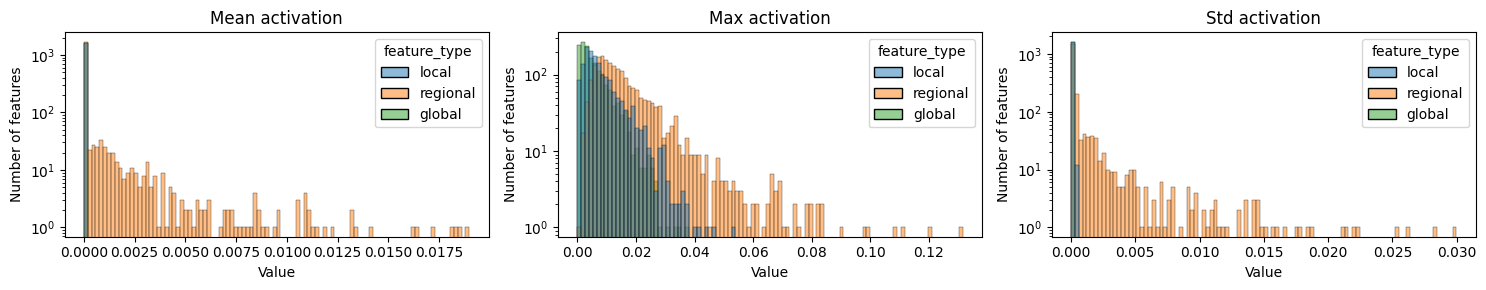

In [137]:
# plot a histogram of the mean, max and std activation for all features

fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.histplot(df_sae_feat_activations[df_sae_feat_activations['feature_type'] != 'dead'], x='mean_activation', hue='feature_type', bins=100, alpha=0.5, ax=ax[0])
ax[0].set_title('Mean activation')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Number of features')
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.histplot(df_sae_feat_activations[df_sae_feat_activations['feature_type'] != 'dead'], x='max_activation', hue='feature_type', bins=100, alpha=0.5, ax=ax[1])
ax[1].set_title('Max activation')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Number of features')
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.histplot(df_sae_feat_activations[df_sae_feat_activations['feature_type'] != 'dead'], x='std_activation', hue='feature_type', bins=100, alpha=0.5, ax=ax[2])
ax[2].set_title('Std activation')
ax[2].set_xlabel('Value')
ax[2].set_ylabel('Number of features')
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
#ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [138]:
# where does my neuron 2306 fall? it should be regional

df_sae_feat_activations[df_sae_feat_activations.index == 2306]

,mean_activation,max_activation,std_activation,feature_type
2306,0.018108,0.13155,0.029983,regional


In [180]:
mean_cos_sim = []
max_cos_sim = []
std_cos_sim = []
n_samples = []
n_features = []
cts = []

# check whether the local features are redundant or at least correlated
for ct in unique_ct_features.keys():
    feats = unique_ct_features[ct]
    ct_samples = torch.tensor(np.where(data.obs['cell_type'] == ct)[0])
    print('Cell type: {} ({} samples, {} features)'.format(ct, len(ct_samples), len(feats)))
    # compute cosine similarity
    activ_temp = activations[ct_samples,:]
    activ_temp = activ_temp[:,feats]
    #cos_sim_local = torch.cosine_similarity(activ_temp, activ_temp, dim=0)
    cos_sim_local = torch.cosine_similarity(activ_temp.unsqueeze(-1), activ_temp.unsqueeze(1), dim=0)
    # get the upper triangular
    cos_sim_local = torch.triu(cos_sim_local, diagonal=1)
    # make the lower triangular nan without removing true zeros
    mask = torch.tril(torch.ones(cos_sim_local.shape), diagonal=0).bool()
    cos_sim_local[mask] = np.nan
    # get the mean, max and min without nan
    cos_sim_local = cos_sim_local[~torch.isnan(cos_sim_local)]
    print(cos_sim_local.max().item(), cos_sim_local.min().item(), cos_sim_local.mean().item())
    print(' ')

    mean_cos_sim.append(cos_sim_local.mean().item())
    max_cos_sim.append(cos_sim_local.max().item())
    std_cos_sim.append(cos_sim_local.std().item())
    n_samples.append(len(ct_samples))
    n_features.append(len(feats))
    cts.append(ct)

Cell type: Naive CD20+ B (4138 samples, 41 features)
0.999998152256012 0.0 0.5805781483650208
 
Cell type: CD14+ Mono (8881 samples, 210 features)
1.0 0.0 0.11743957549333572
 
Cell type: CD8+ T (9491 samples, 10 features)
0.6619457602500916 0.0 0.04236193001270294
 
Cell type: CD16+ Mono (1552 samples, 204 features)
1.0 0.0 0.1170615628361702
 
Cell type: B1 B (1548 samples, 19 features)
0.9997588396072388 0.0 0.20770607888698578
 
Cell type: Lymph prog (1457 samples, 25 features)
1.0 0.0 0.39536547660827637
 
Cell type: CD4+ T naive (3602 samples, 18 features)
0.98072350025177 0.0 0.13798098266124725
 
Cell type: CD4+ T activated (4525 samples, 16 features)
0.9838162660598755 0.0 0.17394433915615082
 
Cell type: Erythroblast (4026 samples, 192 features)
1.0 0.0 0.09430254995822906
 
Cell type: Normoblast (1458 samples, 357 features)
1.0 0.0 0.1302577555179596
 
Cell type: NK (5675 samples, 62 features)
1.0 0.0 0.7022858262062073
 
Cell type: ILC (683 samples, 25 features)
0.999836564

/tmp/ipykernel_1034221/2868634237.py:30: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std_cos_sim.append(cos_sim_local.std().item())


In [191]:
# make this into a dataframe
df_local_cos_sim = pd.DataFrame({
    'mean_cos_sim': mean_cos_sim,
    'max_cos_sim': max_cos_sim,
    'std_cos_sim': std_cos_sim,
    'n_samples': n_samples,
    'n_features': n_features,
    'cell_type': cts
    })

df_local_cos_sim['has_redundancy'] = df_local_cos_sim['max_cos_sim'] > 0.95
df_local_cos_sim

,mean_cos_sim,max_cos_sim,std_cos_sim,n_samples,n_features,cell_type,has_redundancy
0,0.580578,0.999998,0.430340,4138,41,Naive CD20+ B,True
1,0.117440,1.000000,0.235554,8881,210,CD14+ Mono,True
2,0.042362,0.661946,0.115481,9491,10,CD8+ T,False
3,0.117062,1.000000,0.232892,1552,204,CD16+ Mono,True
4,0.207706,0.999759,0.270535,1548,19,B1 B,True
5,0.395365,1.000000,0.441728,1457,25,Lymph prog,True
6,0.137981,0.980724,0.242400,3602,18,CD4+ T naive,True
7,0.173944,0.983816,0.307848,4525,16,CD4+ T activated,True
8,0.094303,1.000000,0.222719,4026,192,Erythroblast,True
9,0.130258,1.000000,0.256412,1458,357,Normoblast,True


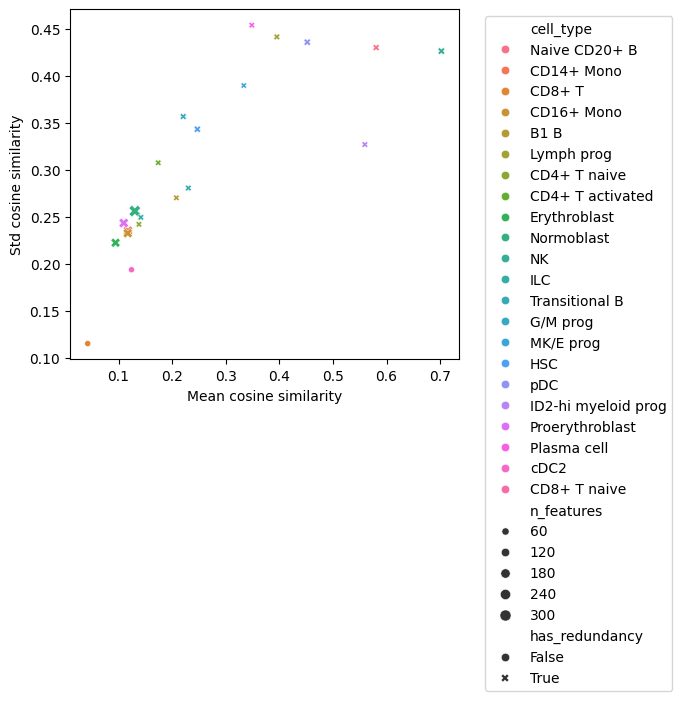

In [192]:
# make a plot with mean on x, std on y, point size n_features, color cell type

fig, ax = plt.subplots(1, 1, figsize=(7,6))
sns.scatterplot(data=df_local_cos_sim, x='mean_cos_sim', y='std_cos_sim', size='n_features', hue='cell_type', style='has_redundancy', ax=ax)
ax.set_xlabel('Mean cosine similarity')
ax.set_ylabel('Std cosine similarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


### How about a graph depicting the connectivity of GO terms and colored by match to SAE features?

# Gene sets of interest

In [ ]:
gsea_sets = {
    'C8': ['HAY_BONE_MARROW'],
    'C7:IMMUNESIGDB': ['NAIVE_VS_EFF_CD8','EFF_VS_MEMORY_CD8','NAIVE_VS_MEMORY_CD8'],
    'C2:CP:CP:KEGG_LEGACY': ['ANTIGEN_PROCESSING_AND_PRESENTATION','APOPTOSIS','B_CELL_RECEPTOR_SIGNALING','HEMATOPOIETIC_CELL_LINEAGE','NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY','T_CELL_RECEPTOR_SIGNALING'],
}